# Gerar gráficos de radar

## Instalar bibliotecas

In [1]:
from pyarrow.dataset import dataset
!pip install transformers torch pandas numpy seaborn matplotlib scikit-learn tqdm



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Definiçoes iniciais

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import re
from math import pi


In [3]:
# Cria um objeto dataset, para armazenar as informações necessárias
class Dataset:
    def __init__(self, name: str):
        self.name = name.lower()
        self.path = os.path.join("..", "data", "02-cleaned", self.name + ".csv")
        self.df = pd.read_csv(self.path)

        print(f"Dataset '{name}' criado com sucesso, com {self.df.shape[0]} registros)!")

    @property
    def toxic_df(self) -> pd.DataFrame:
        return self.df[self.df["is_toxic"]==True]

    @property
    def non_toxic_df(self) -> pd.DataFrame:
        return self.df[self.df["is_toxic"]==False]


In [4]:
 # Definição das categorias e seções do Radar (conforme seu notebook original)
mapeamento_secoes = {
    'Estereótipos Negativos': ['ps', 'rci', 'pa', 'ddf', 'ddp', 'dmc', 'is'],
    'Palavras de Ódio': ['or', 'an', 'asm', 'asf', 'pr', 'om'],
    'Outras Palavras e Insultos': ['qas', 'cds', 're', 'svp']
}

# Lista plana de todas as categorias para facilitar iterações
todas_categorias = [cat for sublist in mapeamento_secoes.values() for cat in sublist]

# Tentativa de carregar a fonte original (se não existir, usa a padrão)
try:
    # Se você tiver o arquivo da fonte na pasta, ele usará
    libertine_font = fm.FontProperties(fname="../assets/LinLibertine_R.ttf")
except:
    libertine_font = fm.FontProperties() # Fonte padrão do sistema


# Lista de objetos de datasets
datasets = [
    Dataset('Fortuna'), Dataset('HateBRXplain'), Dataset('OffComBR3'), Dataset('OLID-BR'), Dataset('ToLD-BR'), Dataset('TuPy')
]

Dataset 'Fortuna' criado com sucesso, com 5666 registros)!
Dataset 'HateBRXplain' criado com sucesso, com 7000 registros)!
Dataset 'OffComBR3' criado com sucesso, com 1029 registros)!
Dataset 'OLID-BR' criado com sucesso, com 6952 registros)!
Dataset 'ToLD-BR' criado com sucesso, com 16806 registros)!
Dataset 'TuPy' criado com sucesso, com 9917 registros)!


In [5]:
def carregar_hatebase(caminho):
    """Lê o HurtLex (CSV) e cria o dicionário de termos -> categorias"""
    try:
        try:
            df = pd.read_csv(caminho)
        except:
            df = pd.read_csv(caminho, sep='\t')

        if 'level' in df.columns:
            df = df[df['level'] == 'conservative']

        if 'lemma' not in df.columns and 'term' in df.columns:
            df.rename(columns={'term': 'lemma'}, inplace=True)

        hatebase = df.groupby('lemma')['category'].apply(list).to_dict()

        print(f"[OK] HurtLex carregado de '{caminho}': {len(hatebase)} termos.")
        return hatebase
    except FileNotFoundError:
        print(f"[ERRO] Arquivo HurtLex não encontrado em: {caminho}")
        return {}
    except Exception as e:
        print(f"[ERRO] Falha ao ler HurtLex: {e}")
        return {}

In [6]:
# Lista ordenada de todas as categorias baseada nas suas seções
# Isso garante que no gráfico, categorias parecidas fiquem vizinhas
categorias_ordenadas = [cat for sublist in mapeamento_secoes.values() for cat in sublist]

# Carrega o HurtLex (usando sua função pronta)
caminho_hurtlex = "../data/02-cleaned/hurtlex_PT_conservatives.csv"

# Verifica se o caminho do hurtlex é um arquivo mesmo
if not os.path.isfile(caminho_hurtlex):
    raise FileNotFoundError("O caminho fornecido para o HurtLex está incorreto.")

hatebase = carregar_hatebase(caminho_hurtlex)

[OK] HurtLex carregado de '../data/02-cleaned/hurtlex_PT_conservatives.csv': 949 termos.


## Calcular distribuição lexica (n-gram)

In [7]:
def calcular_distribuicao_lexica(datasets_obj, hatebase_dict, categorias_alvo, is_toxic: bool | None = True):
    """
    Versão 2.0: Suporta termos compostos (ex: 'filho da puta') usando N-grams.
    """
    
    # Função auxiliar para gerar sequências de palavras
    def gerar_ngrams(lista_palavras, n):
        # Ex: se n=2, gera [('filho', 'da'), ('da', 'puta')...]
        # Depois juntamos com ' ' para virar "filho da"
        return zip(*[lista_palavras[i:] for i in range(n)])

    data = {}
    
    # Descobre qual o tamanho máximo de frase no seu dicionário (para não gerar n-grams à toa)
    # Geralmente no HurtLex o máx é 3 ou 4 palavras. Vamos garantir.
    max_ngram_size = 4 
    
    for ds in datasets_obj:
        print(f"Processando vocabulário de: {ds.name}...")
        
        if is_toxic is None:
            df_selected = ds.df.copy()
        elif is_toxic:
            # Pega apenas textos tóxicos
            df_selected = ds.toxic_df.copy()
        elif not is_toxic:
            # Pega apenas os non-toxic
            df_selected = ds.non_toxic_df.copy()

        
        if df_selected.empty:
            data[ds.name] = [0.0] * len(categorias_alvo)
            continue
            
        # --- 1. Limpeza ---
        # Convertemos tudo para string e minúsculo
        texto_unico = df_selected['text'].astype(str).str.lower().str.cat(sep=' ')
        
        # Removemos pontuação (troca por espaço para não colar palavras)
        texto_limpo = re.sub(r'[^\w\s]', ' ', texto_unico)
        
        # Lista bruta de palavras
        tokens = texto_limpo.split()
        
        # --- 2. Contagem com N-grams ---
        contagem = {cat: 0 for cat in categorias_alvo}
        total_matches = 0
        
        # Vamos iterar de 1 até 4 (unigramas, bigramas, trigramas, quadrigramas)
        for n in range(1, max_ngram_size + 1):
            
            # Gera as sequências (ex: "filho da puta")
            ngrams_tuples = gerar_ngrams(tokens, n)
            
            for tupa_palavras in ngrams_tuples:
                termo = " ".join(tupa_palavras) # Junta ('filho', 'da') em "filho da"
                
                # Verifica se esse termo composto existe no dicionário
                if termo in hatebase_dict:
                    cats_encontradas = hatebase_dict[termo]
                    
                    for cat in cats_encontradas:
                        if cat in contagem:
                            contagem[cat] += 1
                            total_matches += 1
                            
        # --- 3. Normalização ---
        if total_matches > 0:
            percentuais = [(contagem[cat] / total_matches) * 100 for cat in categorias_alvo]
        else:
            percentuais = [0.0] * len(categorias_alvo)
            
        data[ds.name] = percentuais

    return pd.DataFrame(data, index=categorias_alvo)

### Teste ódio

In [8]:
# # Passo 1: Calcular
# df_radar_1 = calcular_distribuicao_lexica(datasets, hatebase, categorias_ordenadas)

# # (Opcional) Ver os números antes de plotar
# print("Tabela de Porcentagens:")
# display(df_radar_1)

## Calcular distribuição lexica (por palavra)

In [9]:
# def calcular_distribuicao_lexica(datasets_obj, hatebase_dict, categorias_alvo, is_toxic: bool | None = True):
#     """
#     Percorre os datasets, conta os termos do HurtLex e calcula a % de cada categoria.
#     Retorna um DataFrame onde:
#     - Linhas = Categorias
#     - Colunas = Datasets
#     - Valores = % de presença (0-100)
#     """
#     data = {}
    
#     for ds in datasets_obj:
#         print(f"Processando vocabulário de: {ds.name}...")
        
#         if is_toxic is None:
#             df_selected = ds.df.copy()
#         elif is_toxic:
#             # Pega apenas textos tóxicos
#             df_selected = ds.toxic_df
#         elif not is_toxic:
#             # Pega apenas os non-toxic
#             df_selected = ds.non_toxic_df

#         # Proteção para dataset vazio
#         if df_selected.empty:
#             data[ds.name] = [0] * len(categorias_alvo)
#             continue
            
#        # 2. Tokenização Otimizada:
#         # Passo A: Converte tudo para string e minúsculo
#         texto_unico = df_selected['text'].astype(str).str.lower().str.cat(sep=' ')
        
#         # Passo B: Remove pontuação (Substitui tudo que NÃO for letra/número/espaço por um espaço em branco)
#         # O padrão r'[^\w\s]' significa "qualquer coisa exceto (^) palavra (\w) ou espaço (\s)"
#         texto_limpo = re.sub(r'[^\w\s]', ' ', texto_unico)
        
#         # Passo C: Divide pelos espaços (o split já ignora espaços múltiplos criados acima)
#         todas_palavras = texto_limpo.split()

#         # print(todas_palavras[0:100])

#         # 3. Contagem
#         contagem = {cat: 0 for cat in categorias_alvo}
#         total_matches = 0
        
#         for palavra in todas_palavras:
#             if palavra in hatebase_dict:
#                 # Uma palavra pode ter várias categorias (ex: 'macaco' -> ['an', 'as'])
#                 cats_encontradas = hatebase_dict[palavra]
                
#                 for cat in cats_encontradas:
#                     if cat in contagem:
#                         contagem[cat] += 1
#                         total_matches += 1
        
#         # 4. Normalização (Cálculo da %)
#         # Se encontrei 100 ofensas e 20 são 'an', então 'an' = 20%
#         if total_matches > 0:
#             percentuais = [(contagem[cat] / total_matches) * 100 for cat in categorias_alvo]
#         else:
#             percentuais = [0] * len(categorias_alvo)
            
#         data[ds.name] = percentuais

#     return pd.DataFrame(data, index=categorias_alvo)

### Teste ódio

In [10]:
# # Passo 1: Calcular
# df_radar_2 = calcular_distribuicao_lexica(datasets, hatebase, categorias_ordenadas)

# # (Opcional) Ver os números antes de plotar
# print("Tabela de Porcentagens:")
# display(df_radar_2)

In [11]:
# df_radar_1 == df_radar_2

## Plotar o radar

In [12]:
def plotar_radares_finais(df_percentuais: pd.DataFrame, mapeamento_secoes: dict, y_limit:int=30, output_path:str = '../outputs/radares'):
    """
    Gera gráficos de radar com ordem fixa de categorias baseada no mapeamento.
    Garante que 'Estereótipos', 'Ódio', etc. fiquem sempre na mesma posição.
    """
    
    # --- 1. Configurações Visuais e de Arquivo ---
    # output_path = './output/radares'
    # os.makedirs(output_path, exist_ok=True)


    try:
        # Tenta carregar a fonte Libertine (ajuste o caminho se necessário)
        libertine_font = fm.FontProperties(fname="../assets/LinLibertine_R.ttf") 
    except:
        libertine_font = fm.FontProperties() # Fallback

    # Estilos (Cores e Tamanhos)
    tamanho_fonte_secoes = 16
    tamanho_fonte_eixos = 28
    tamanho_fonte_ticks = 20
    cores_fill = ['#4C1A57', '#FF3CC7', '#9E3CA8'] # Roxo Escuro, Rosa Choque, Roxo Médio

    # --- 2. Definição da Ordem (A Fonte da Verdade) ---
    # Aqui garantimos que a ordem visual será sempre: Estereótipos -> Ódio -> Outros
    # Independente de como o DataFrame esteja ordenado.
    labels_ordenados = [cat for sublist in mapeamento_secoes.values() for cat in sublist]
    num_vars = len(labels_ordenados)
    
    # Ângulos (Iguais para todos os gráficos)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles_fechado = angles + angles[:1]

    # --- 3. Loop: Gera um Gráfico por Dataset ---
    for dataset_nome in df_percentuais.columns:
        
        print(f"Gerando radar para: {dataset_nome}...")
        
        # --- O SEGREDO DA ORDEM ESTÁ AQUI ---
        # .reindex(labels_ordenados): Reorganiza as linhas do DF para bater com o mapeamento
        # .fillna(0): Se o dataset não tiver aquela categoria, coloca 0 em vez de dar erro
        dados_dataset = df_percentuais[dataset_nome].reindex(labels_ordenados).fillna(0)
        
        values = dados_dataset.tolist()
        values_fechado = values + values[:1]

        # Configuração da Figura
        fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
        ax.set_facecolor('#f5f5f5')

        # Plota a Linha Principal
        ax.plot(angles_fechado, values_fechado, linewidth=2, linestyle='solid', color="gray", zorder=10)

        # --- Preenchimento das Seções (Fundo Colorido) ---
        start_idx = 0
        for i, (secao, categorias_da_secao) in enumerate(mapeamento_secoes.items()):
            num_cats = len(categorias_da_secao)
            end_idx = start_idx + num_cats
            
            # Cria vetor zerado e preenche apenas o trecho da seção atual
            valores_secao = np.zeros(len(values_fechado))
            valores_secao[start_idx:end_idx+1] = values_fechado[start_idx:end_idx+1]
            
            ax.fill(angles_fechado, valores_secao, color=cores_fill[i % len(cores_fill)], alpha=0.6, label=secao)
            start_idx = end_idx

        # --- Formatação dos Rótulos (Categorias) ---
        ax.set_thetagrids(np.degrees(angles), labels_ordenados)
        for label in ax.get_xticklabels():
            label.set_fontproperties(libertine_font)
            label.set_fontsize(tamanho_fonte_eixos)

        # --- Formatação dos Ticks (Porcentagens) ---
        yticks = np.arange(10, y_limit + 1, 10)
        ax.set_yticks(yticks)
        ax.set_yticklabels([]) # Esconde labels padrão
        
        # Desenha os números de % manualmente
        angle_text_deg = 145
        angle_text_rad = np.deg2rad(angle_text_deg)
        for n, tick in enumerate(yticks):
            ax.text(x=angle_text_rad + ((n + 0.75) / 180),
                    y=tick,
                    s=f"{tick}%",
                    color="gray",
                    fontproperties=libertine_font,
                    fontsize=tamanho_fonte_ticks,
                    horizontalalignment='center',
                    verticalalignment='bottom')

        plt.ylim(0, y_limit)
        ax.tick_params(axis='x', pad=30)
        ax.set_rlabel_position(45)

        # --- Linhas Divisórias (Pontilhadas) ---
        angulo_por_eixo = 2 * np.pi / num_vars
        angulo_acumulado = 0
        for i, (secao, categorias_da_secao) in enumerate(mapeamento_secoes.items()):
            num_cats_na_secao = len(categorias_da_secao)
            if i < len(mapeamento_secoes) - 1:
                angulo_linha = angulo_acumulado + (num_cats_na_secao * angulo_por_eixo)
                ax.plot([angulo_linha, angulo_linha], [0, y_limit],
                        color='black', linestyle=':', linewidth=1.2)
                angulo_acumulado = angulo_linha

        # --- Título e Salvamento ---
        
        # Adiciona Título (Descomentei pois é importante para o gráfico salvo)
        # plt.title(f"Perfil de Ódio: {dataset_nome.title()}", fontsize=20, pad=40, fontproperties=libertine_font, weight='bold')

        # Define o nome do arquivo
        nome_arquivo = f"radar_{dataset_nome.lower().replace(' ', '_')}.pdf"
        caminho_completo = os.path.join(output_path, nome_arquivo)

        # Verifica se o caminho já existe, se nãom cria
        os.makedirs(os.path.dirname(caminho_completo), exist_ok=True)
        
        # Salva o arquivo
        # bbox_inches='tight' garante que labels longos não sejam cortados
        plt.savefig(caminho_completo, format='pdf', bbox_inches='tight')
        
        print(f"[Salvo] {caminho_completo}")
        plt.show() 
        plt.close(fig)

# Para usar:
# plotar_radares_finais(df_radar, mapeamento_secoes)

## Gerando para ódio

Processando vocabulário de: fortuna...
Processando vocabulário de: hatebrxplain...
Processando vocabulário de: offcombr3...
Processando vocabulário de: olid-br...
Processando vocabulário de: told-br...
Processando vocabulário de: tupy...
Tabela de Distribuição (%):


,fortuna,hatebrxplain,offcombr3,olid-br,told-br,tupy
ps,2.7,3.7,6.8,5.1,6.3,4.6
rci,0.1,0.1,0.0,0.0,0.0,0.0
pa,0.1,0.1,0.0,0.0,0.0,0.0
ddf,5.8,0.7,1.0,0.8,3.4,2.3
ddp,5.9,9.9,14.6,10.3,11.0,7.7
dmc,6.2,11.8,6.3,8.6,4.2,8.8
is,1.2,2.8,1.9,1.9,1.0,2.8
or,9.1,3.3,8.3,5.8,3.6,7.1
an,8.1,12.4,18.4,15.2,14.0,10.6
asm,5.8,5.3,3.4,8.8,21.4,5.7


Gerando radar para: fortuna...
[Salvo] ../outputs/radares/toxic/radar_fortuna.pdf


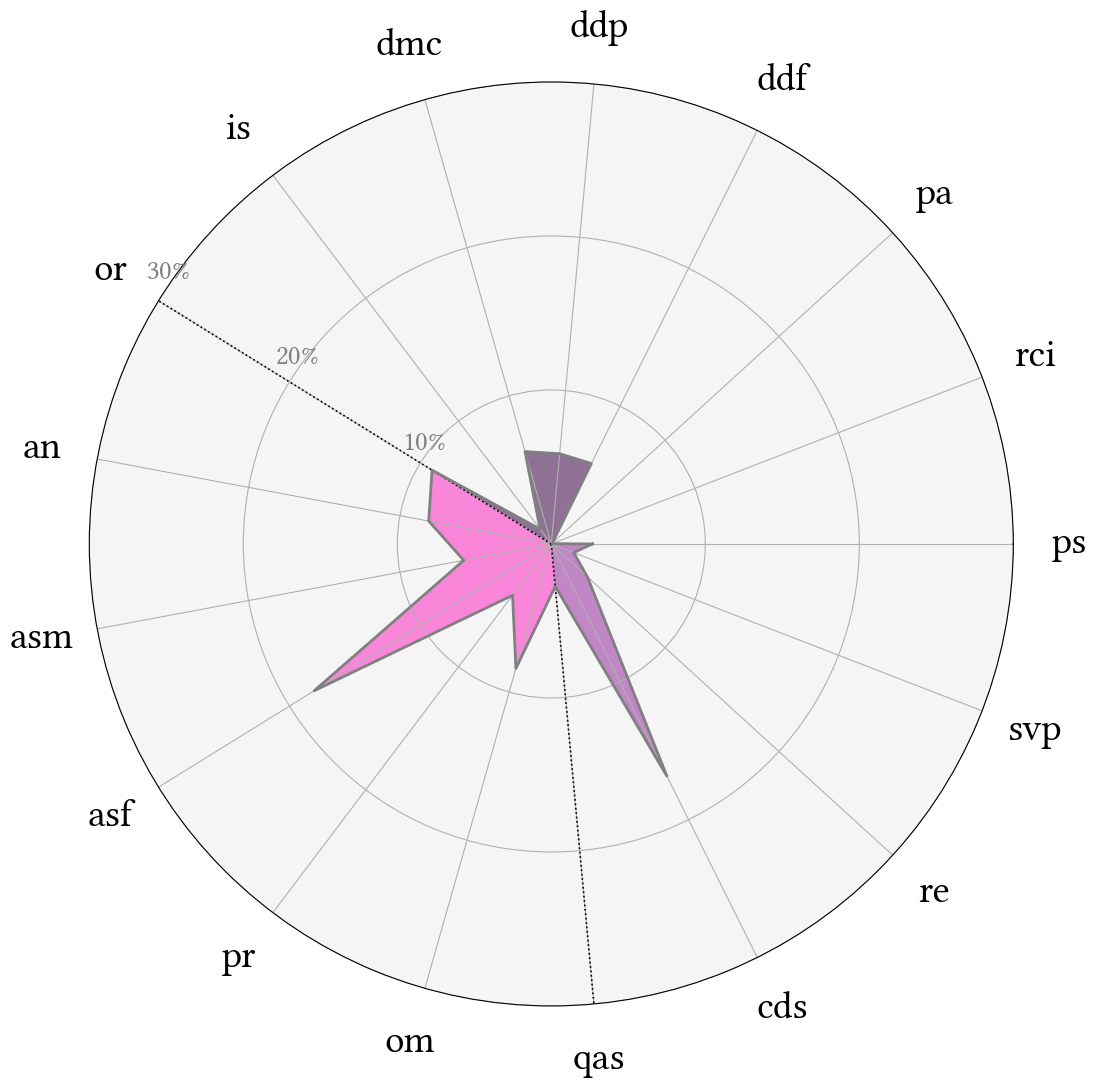

Gerando radar para: hatebrxplain...
[Salvo] ../outputs/radares/toxic/radar_hatebrxplain.pdf


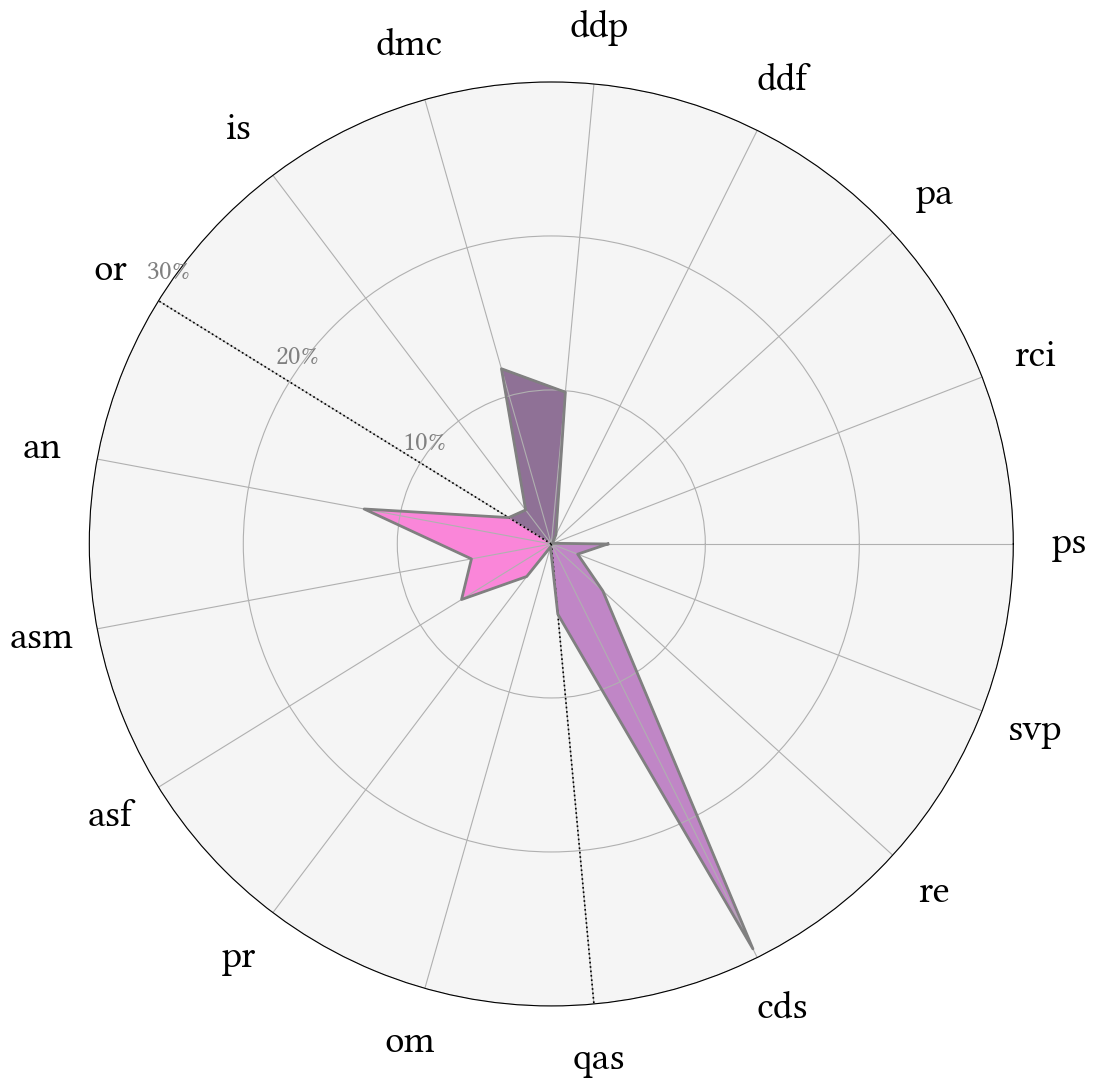

Gerando radar para: offcombr3...
[Salvo] ../outputs/radares/toxic/radar_offcombr3.pdf


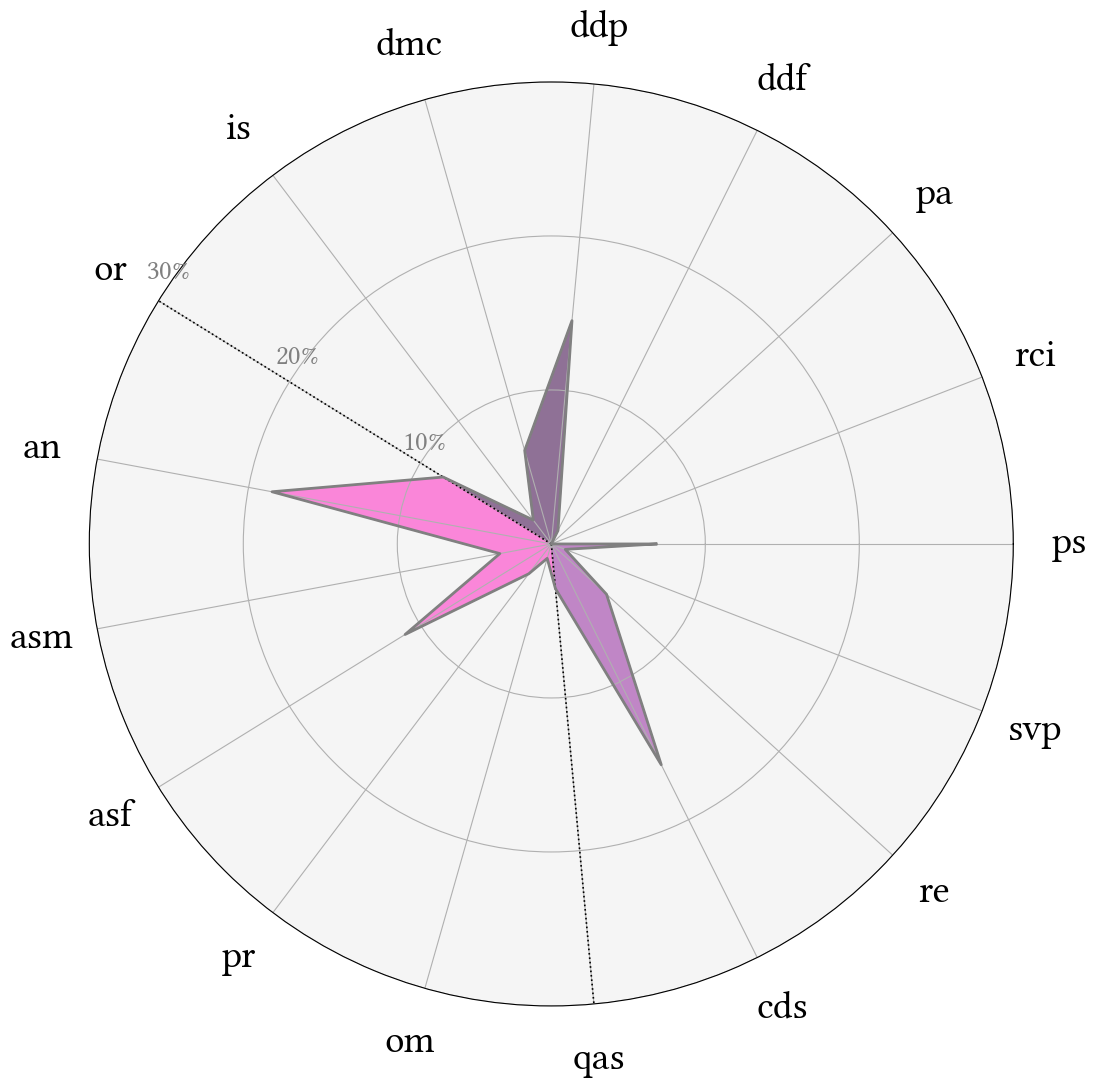

Gerando radar para: olid-br...
[Salvo] ../outputs/radares/toxic/radar_olid-br.pdf


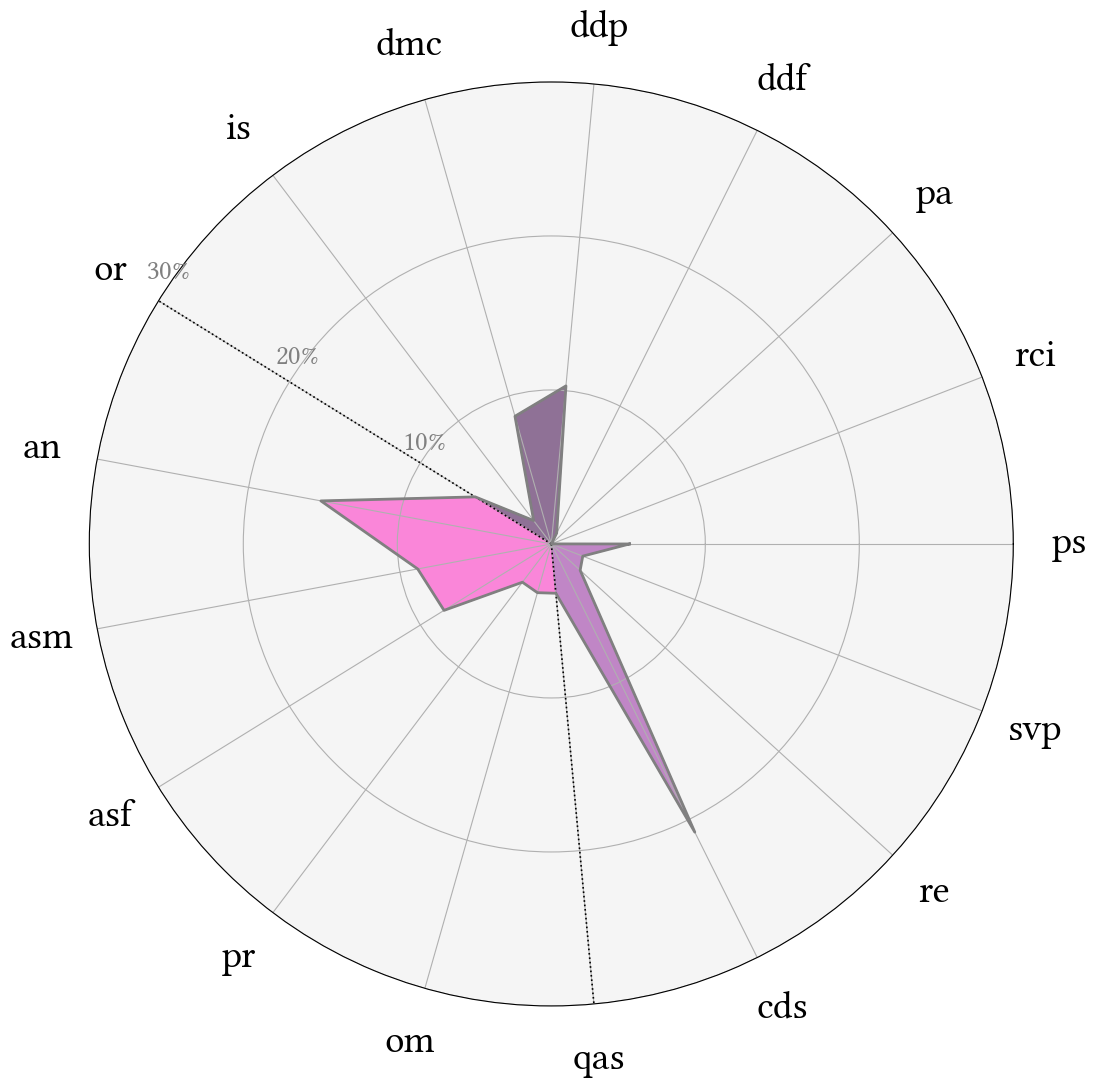

Gerando radar para: told-br...
[Salvo] ../outputs/radares/toxic/radar_told-br.pdf


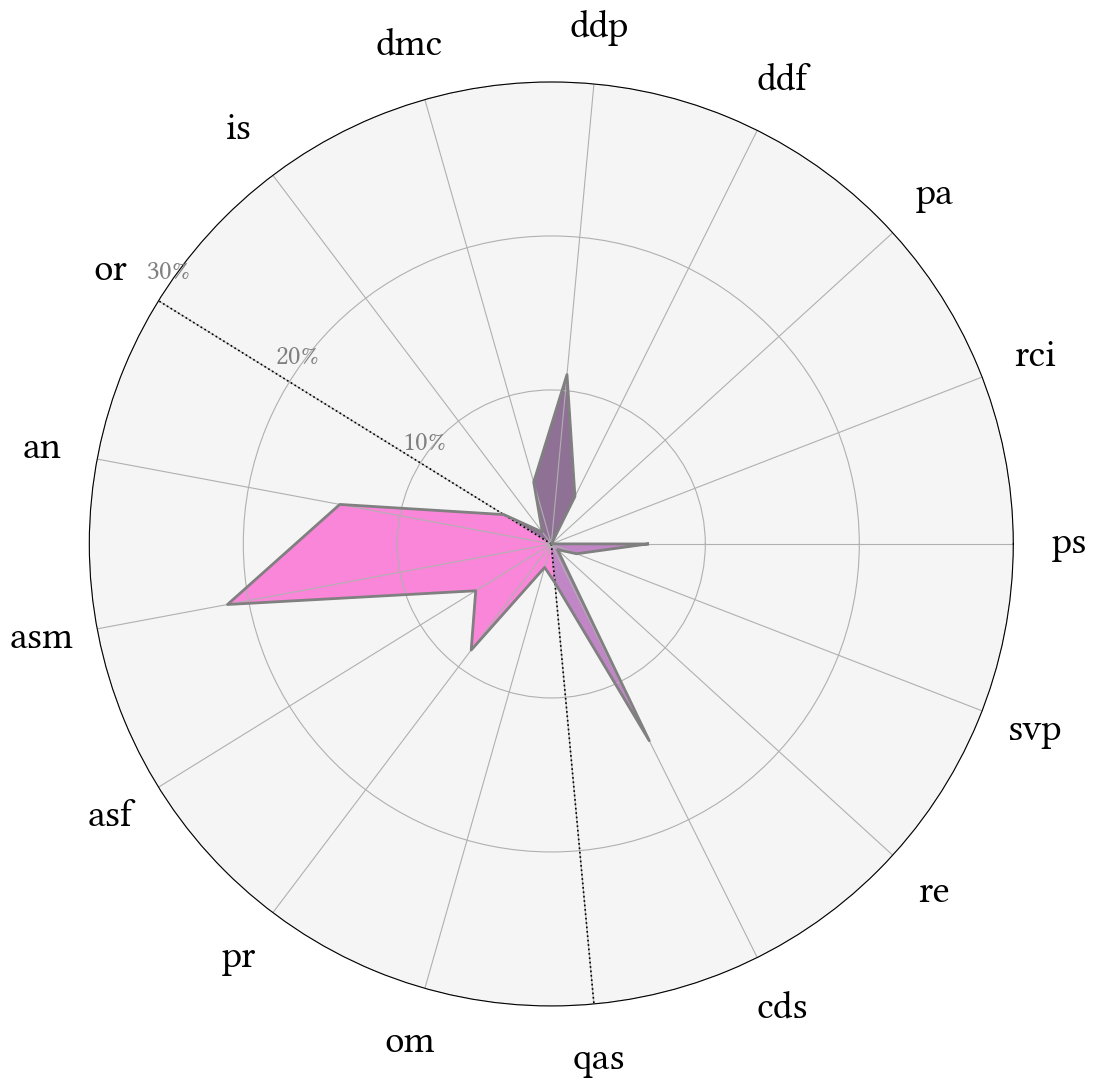

Gerando radar para: tupy...
[Salvo] ../outputs/radares/toxic/radar_tupy.pdf


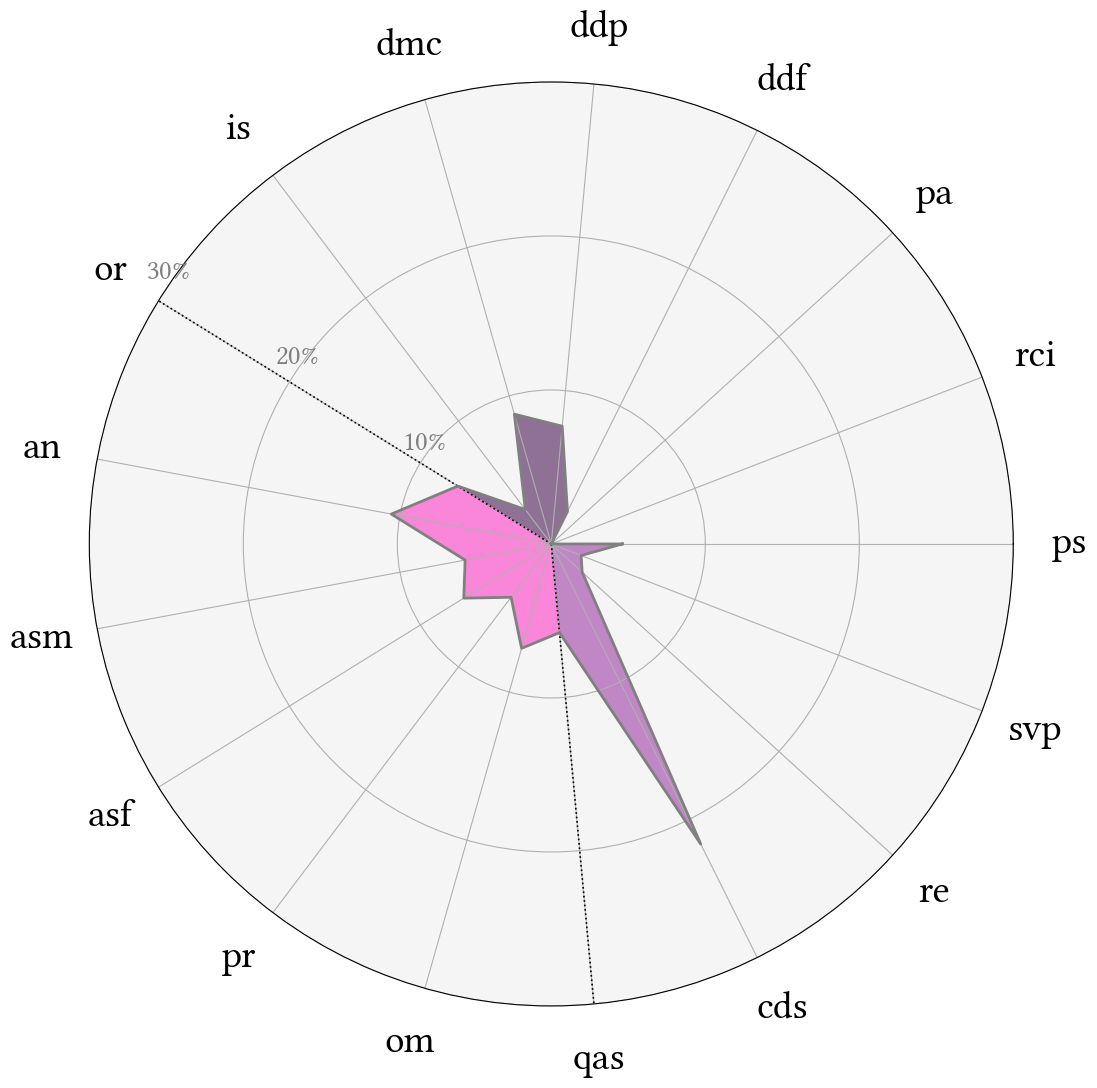

In [13]:
# 1. Calcular a tabela de dados
# (Certifique-se de que 'datasets' é sua lista de objetos Dataset e 'hatebase' está carregado)
df_radar = calcular_distribuicao_lexica(datasets, hatebase, categorias_ordenadas, is_toxic=True)

# 2. Conferir os números (Opcional)
print("Tabela de Distribuição (%):")
display(df_radar.round(1))

# 3. Gerar os Gráficos
# plotar_radares_individuais(df_radar, mapeamento_secoes)
plotar_radares_finais(df_radar, mapeamento_secoes,output_path='../outputs/radares/toxic')

# Gerando para não ódio

Processando vocabulário de: fortuna...
Processando vocabulário de: hatebrxplain...
Processando vocabulário de: offcombr3...
Processando vocabulário de: olid-br...
Processando vocabulário de: told-br...
Processando vocabulário de: tupy...
Tabela de Distribuição (%):


,fortuna,hatebrxplain,offcombr3,olid-br,told-br,tupy
ps,2.9,1.2,6.8,3.4,7.7,6.6
rci,0.1,0.1,0.0,0.2,0.0,0.0
pa,0.1,0.1,0.0,0.2,0.0,0.1
ddf,4.5,0.6,0.0,2.2,6.2,0.9
ddp,4.9,3.4,7.8,8.1,6.0,8.3
dmc,8.2,5.3,12.3,7.9,5.2,9.5
is,1.7,3.2,2.3,3.0,1.6,3.0
or,5.4,0.9,4.1,8.0,3.2,2.3
an,4.2,1.8,5.9,5.8,10.9,9.1
asm,5.6,2.6,4.6,6.6,17.2,10.9


Gerando radar para: fortuna...
[Salvo] ../outputs/radares/n_toxic/radar_fortuna.pdf


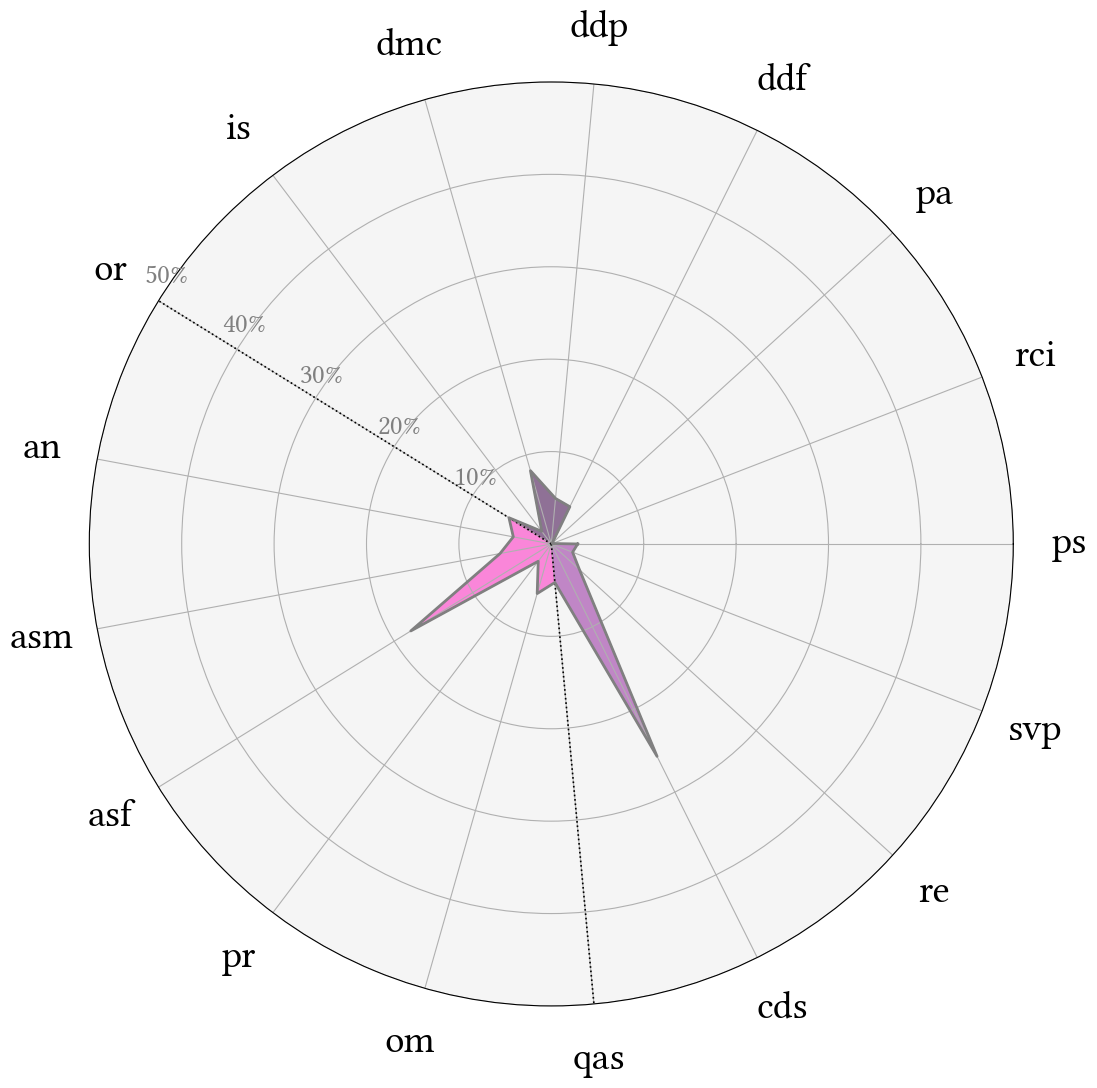

Gerando radar para: hatebrxplain...
[Salvo] ../outputs/radares/n_toxic/radar_hatebrxplain.pdf


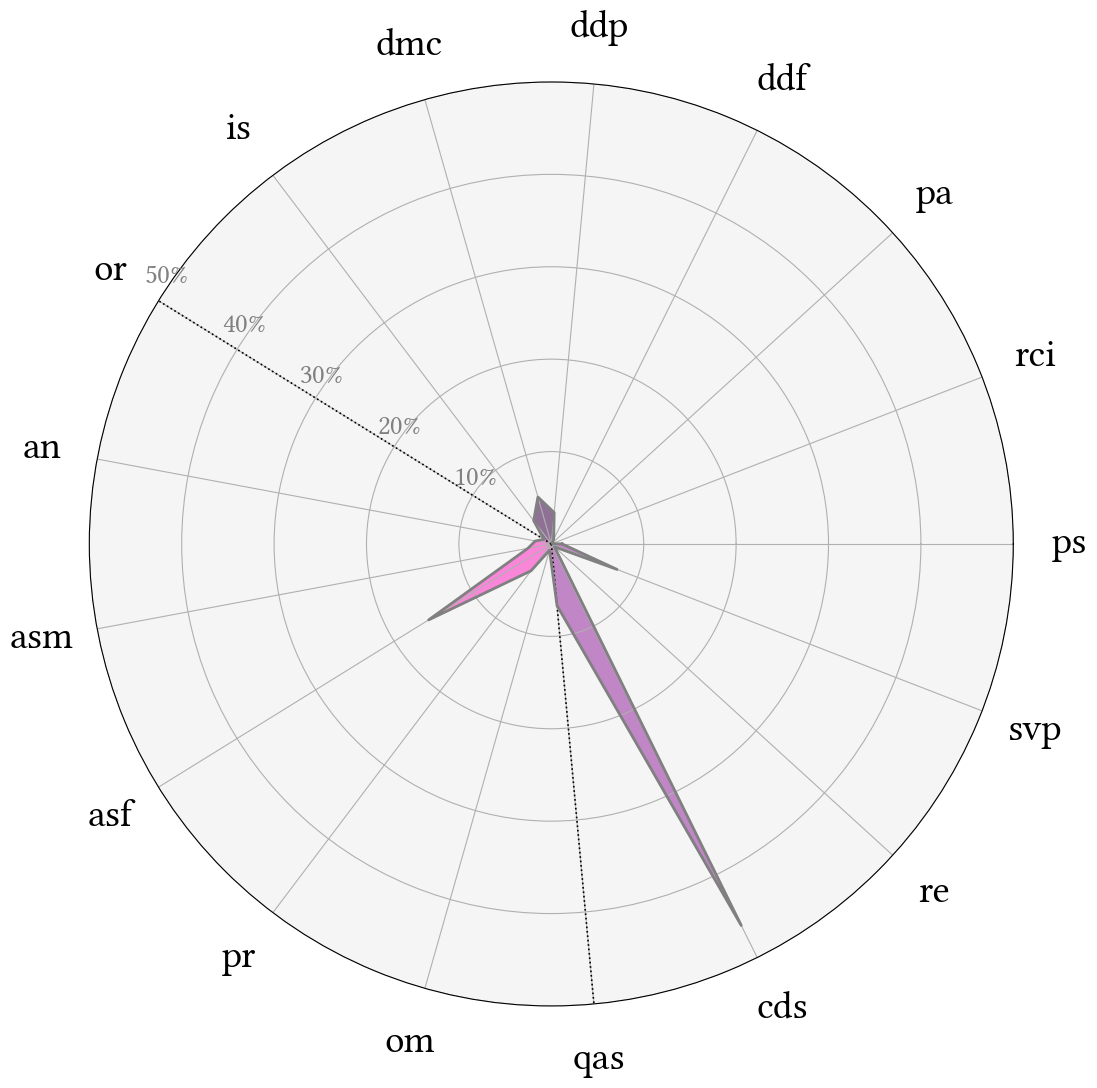

Gerando radar para: offcombr3...
[Salvo] ../outputs/radares/n_toxic/radar_offcombr3.pdf


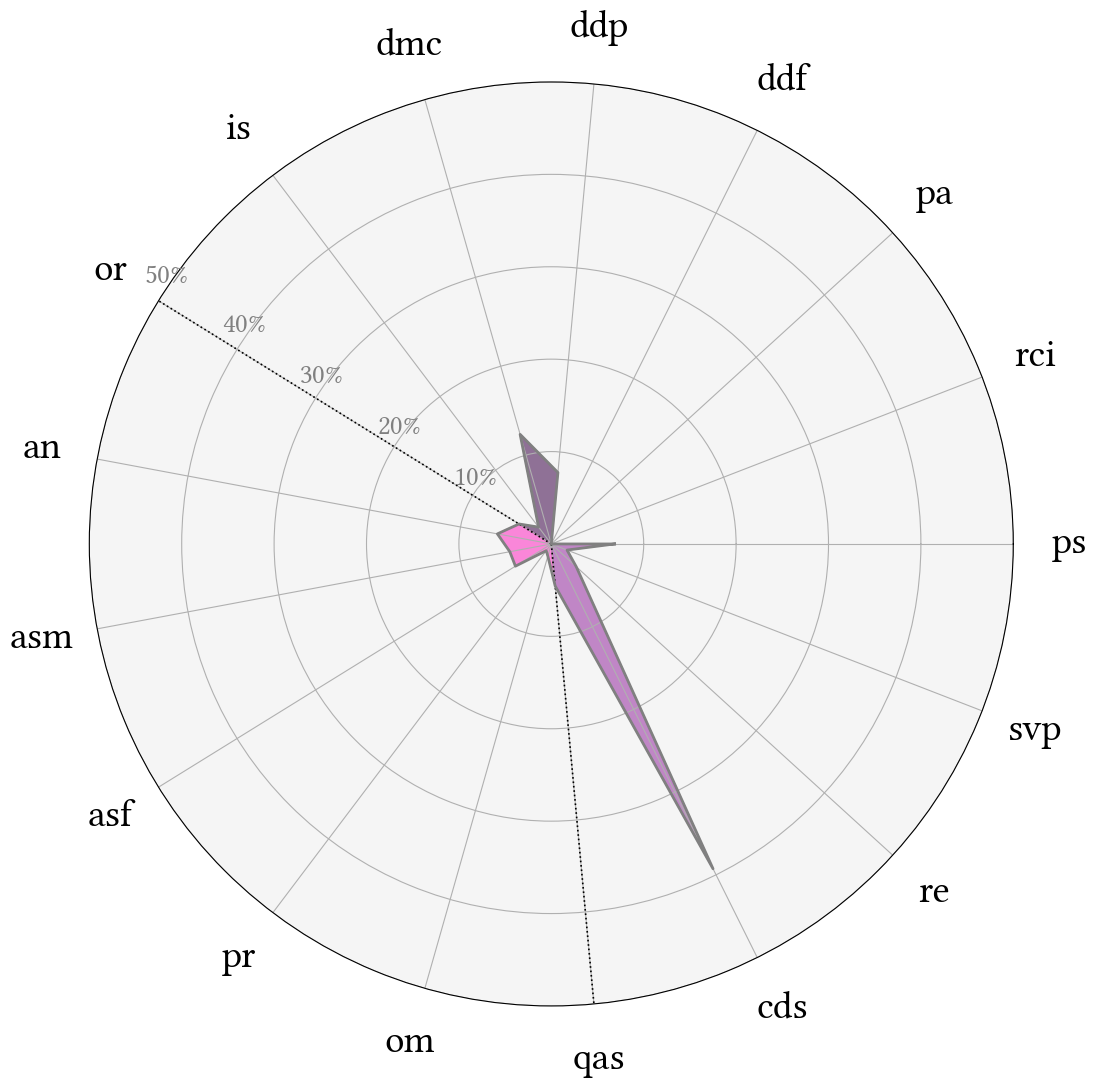

Gerando radar para: olid-br...
[Salvo] ../outputs/radares/n_toxic/radar_olid-br.pdf


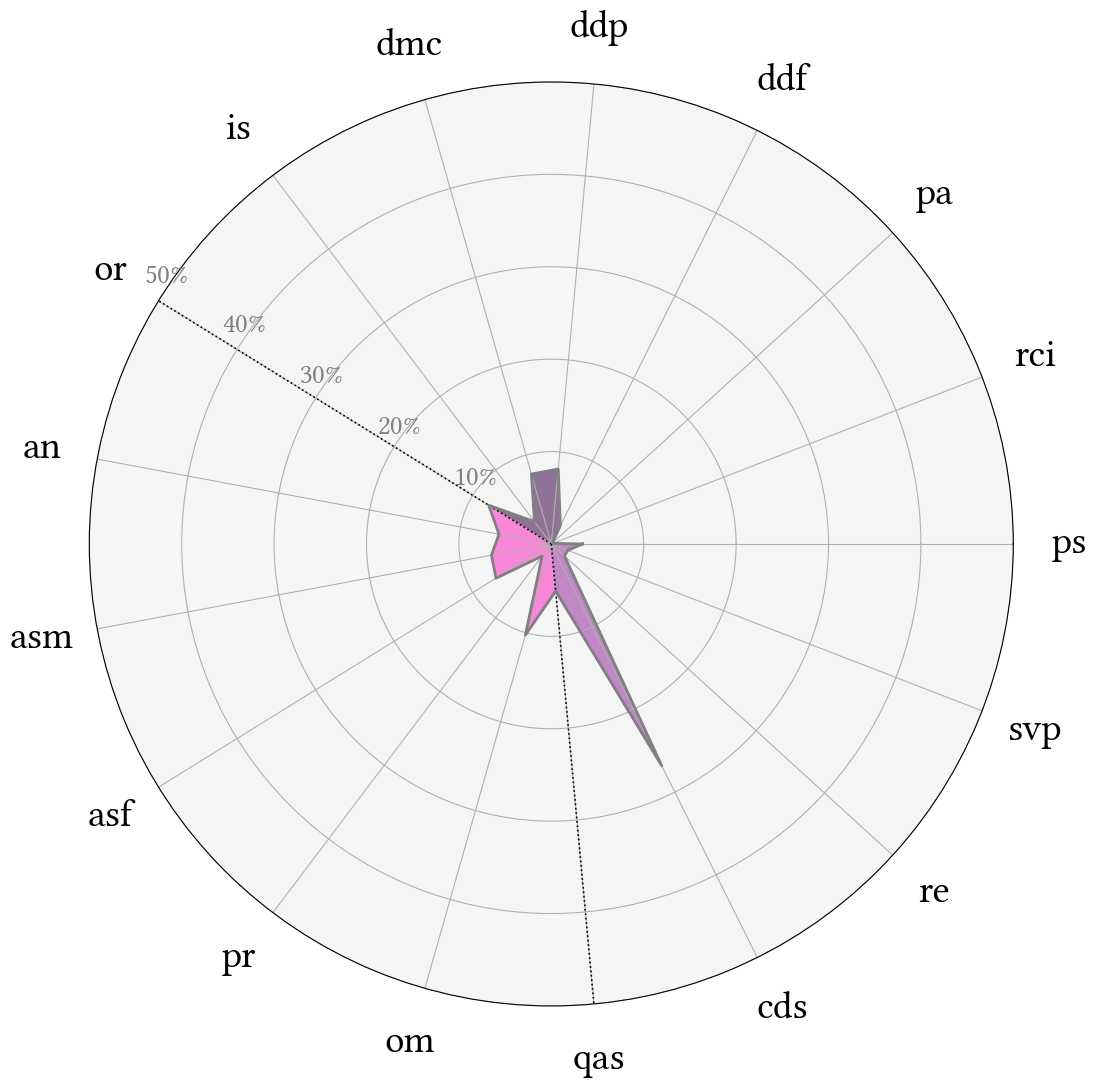

Gerando radar para: told-br...
[Salvo] ../outputs/radares/n_toxic/radar_told-br.pdf


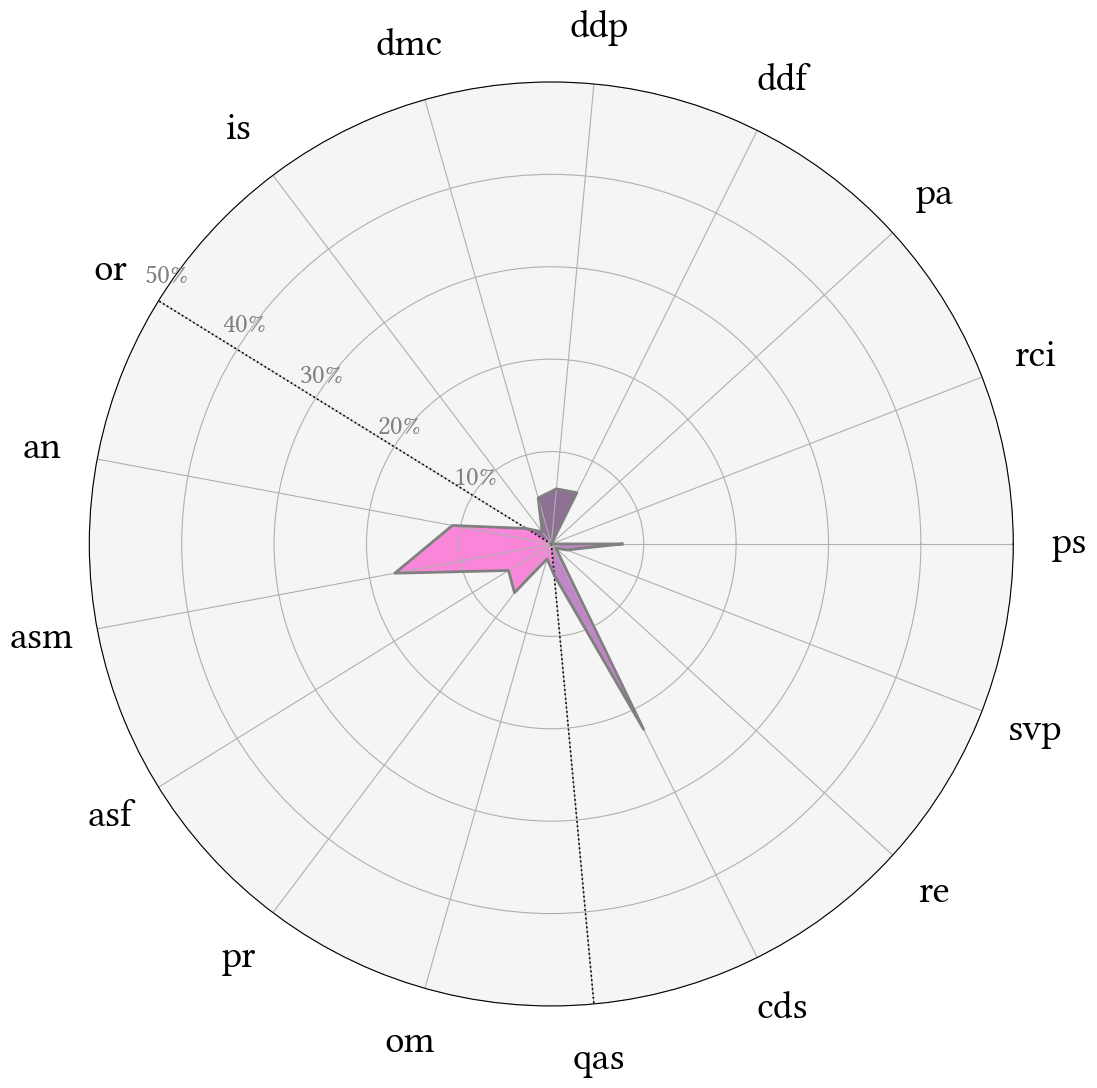

Gerando radar para: tupy...
[Salvo] ../outputs/radares/n_toxic/radar_tupy.pdf


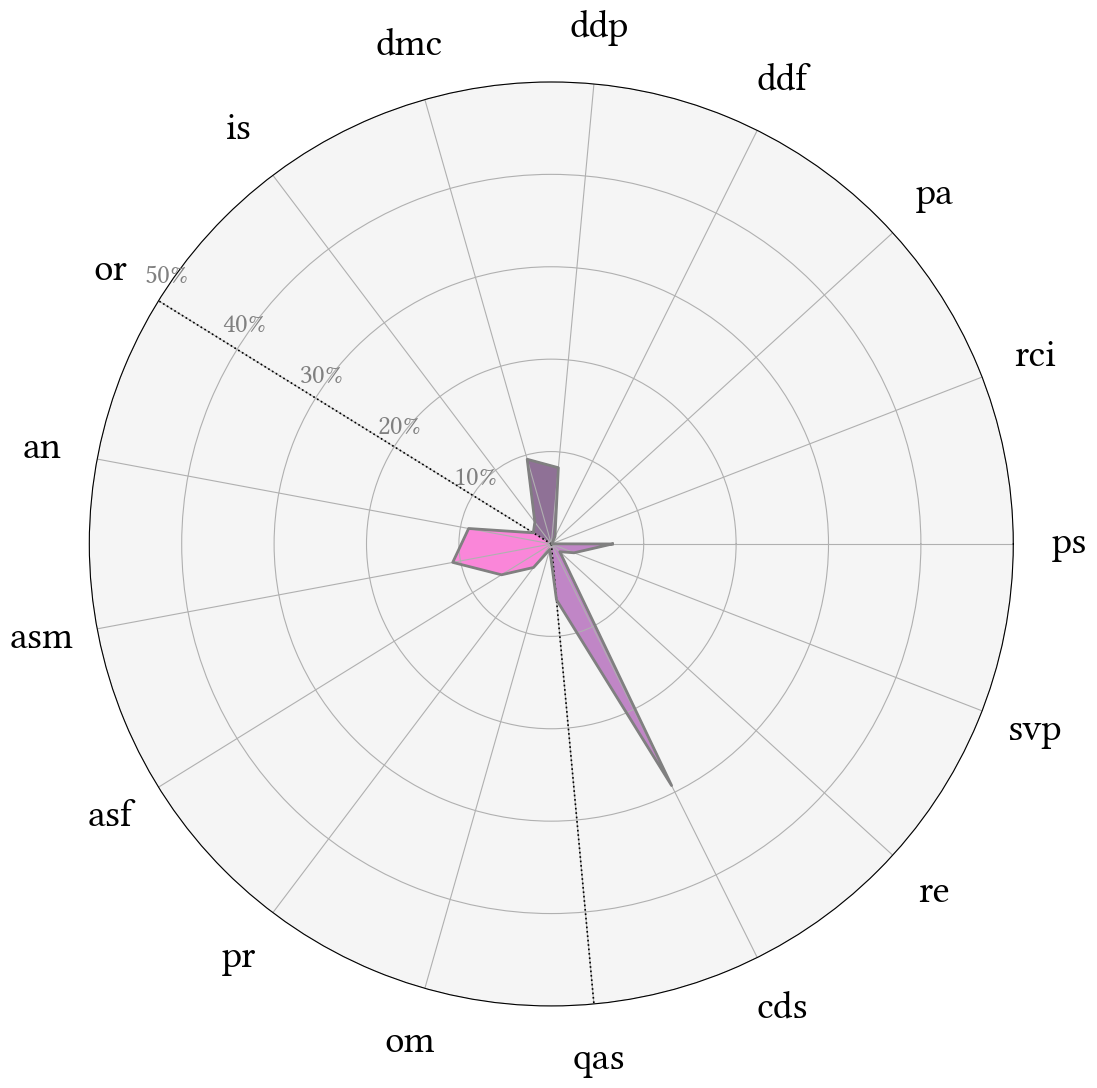

In [14]:
# 1. Calcular a tabela de dados
# (Certifique-se de que 'datasets' é sua lista de objetos Dataset e 'hatebase' está carregado)
df_radar = calcular_distribuicao_lexica(datasets, hatebase, categorias_ordenadas, is_toxic=False)

# 2. Conferir os números (Opcional)
print("Tabela de Distribuição (%):")
display(df_radar.round(1))

# 3. Gerar os Gráficos
# plotar_radares_individuais(df_radar, mapeamento_secoes)
plotar_radares_finais(df_radar, mapeamento_secoes,output_path='../outputs/radares/n_toxic', y_limit=50)

# Gerando para tudo

Processando vocabulário de: fortuna...
Processando vocabulário de: hatebrxplain...
Processando vocabulário de: offcombr3...
Processando vocabulário de: olid-br...
Processando vocabulário de: told-br...
Processando vocabulário de: tupy...
Tabela de Distribuição (%):


,fortuna,hatebrxplain,offcombr3,olid-br,told-br,tupy
ps,2.7,3.3,6.8,4.9,7.0,6.0
rci,0.1,0.1,0.0,0.0,0.0,0.0
pa,0.1,0.1,0.0,0.0,0.0,0.1
ddf,5.2,0.7,0.5,0.9,4.9,1.3
ddp,5.5,8.8,11.1,10.1,8.3,8.1
dmc,7.1,10.7,9.4,8.6,4.7,9.3
is,1.4,2.8,2.1,2.0,1.3,2.9
or,7.5,2.9,6.1,6.0,3.4,3.8
an,6.4,10.6,12.0,14.3,12.3,9.5
asm,5.7,4.8,4.0,8.6,19.2,9.3


Gerando radar para: fortuna...
[Salvo] ../outputs/radares/all/radar_fortuna.pdf


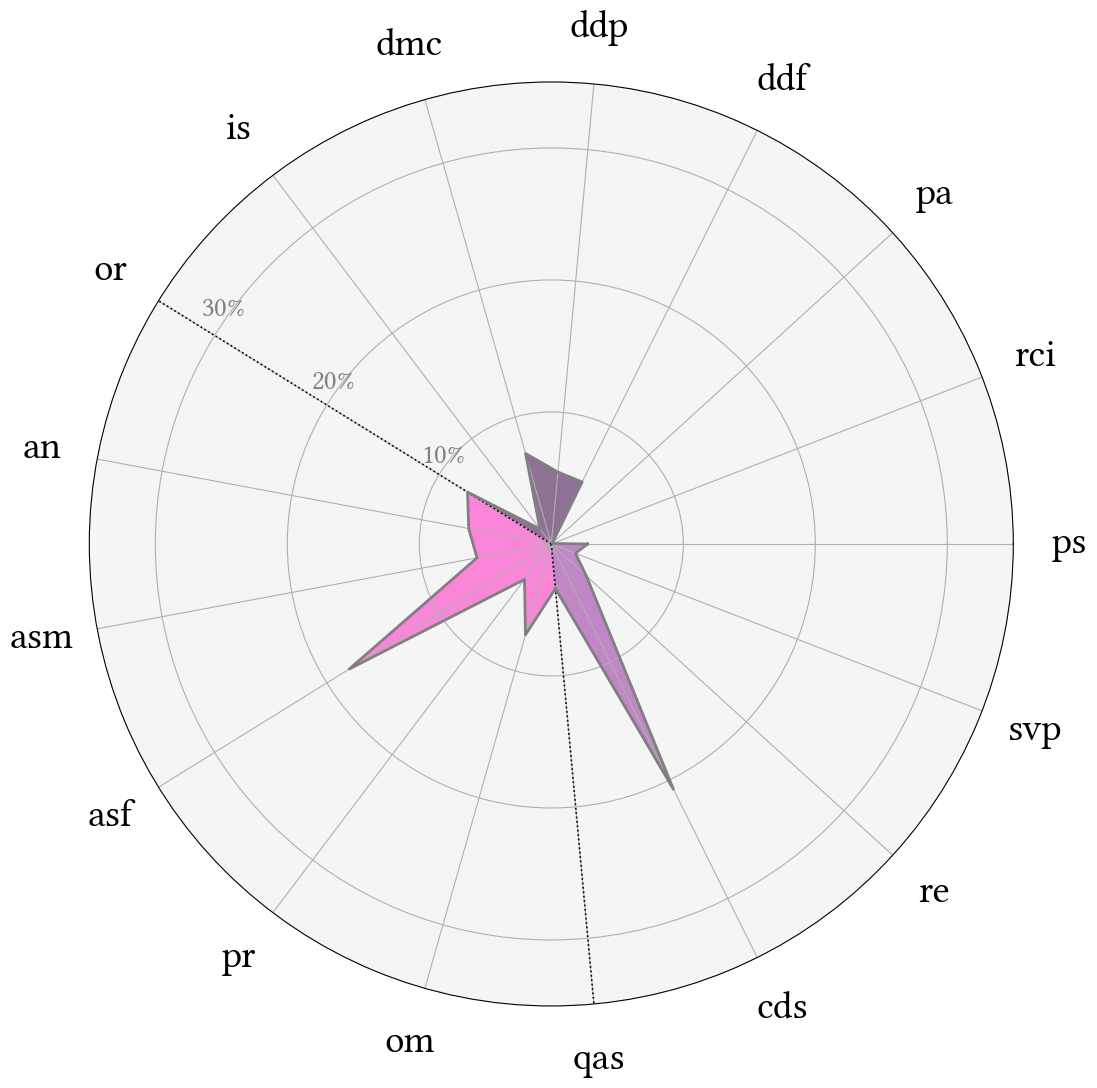

Gerando radar para: hatebrxplain...
[Salvo] ../outputs/radares/all/radar_hatebrxplain.pdf


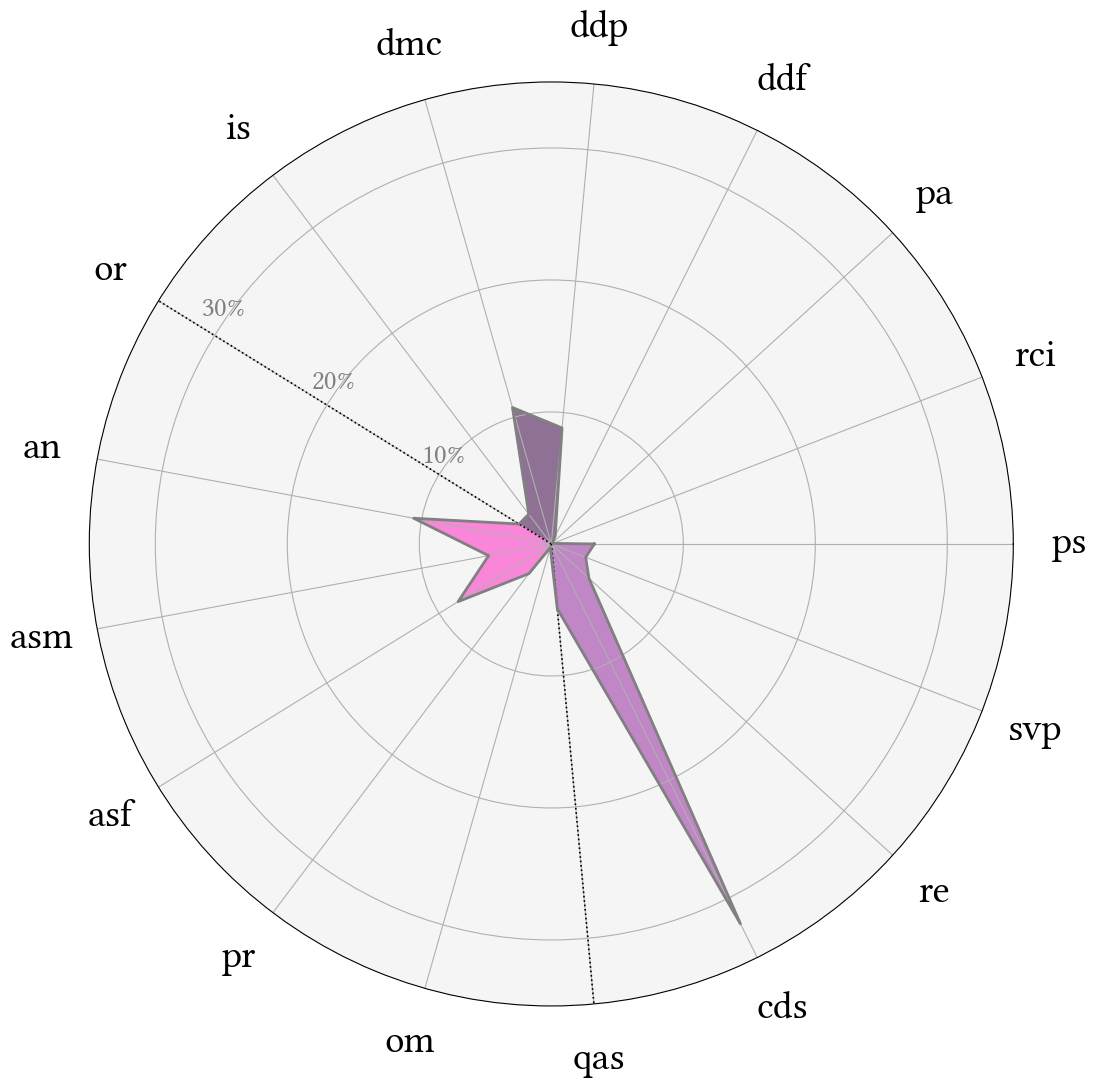

Gerando radar para: offcombr3...
[Salvo] ../outputs/radares/all/radar_offcombr3.pdf


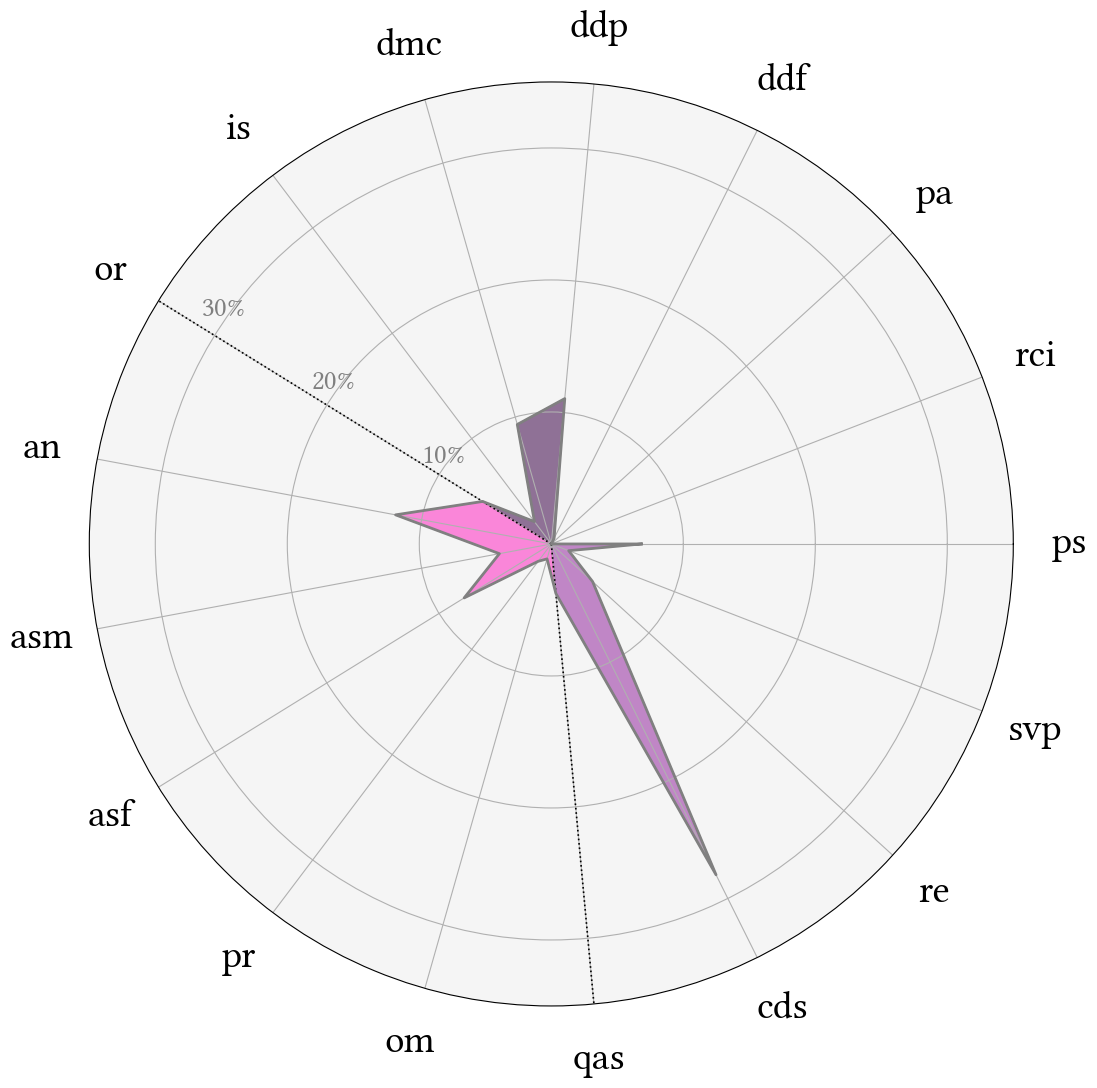

Gerando radar para: olid-br...
[Salvo] ../outputs/radares/all/radar_olid-br.pdf


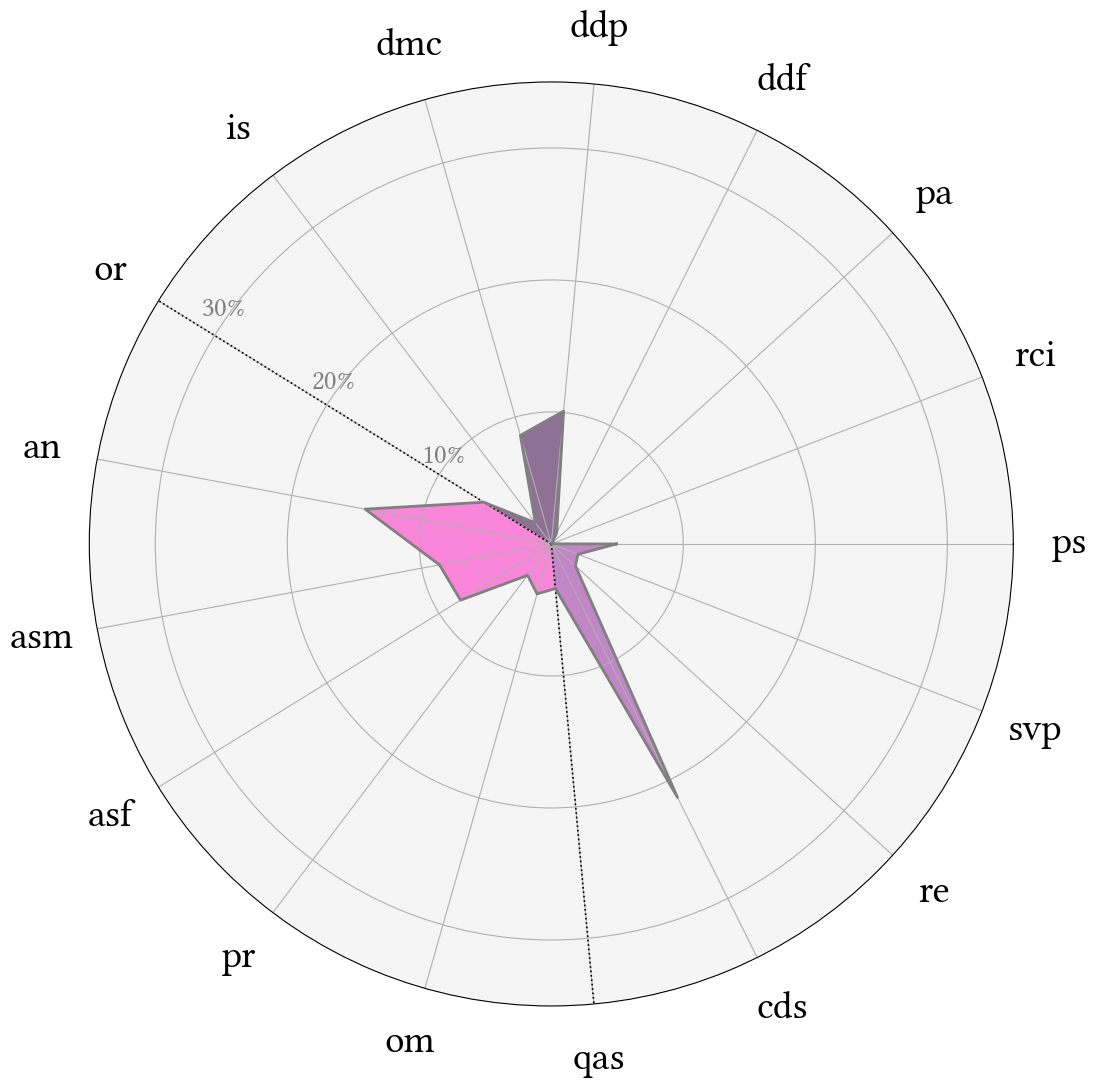

Gerando radar para: told-br...
[Salvo] ../outputs/radares/all/radar_told-br.pdf


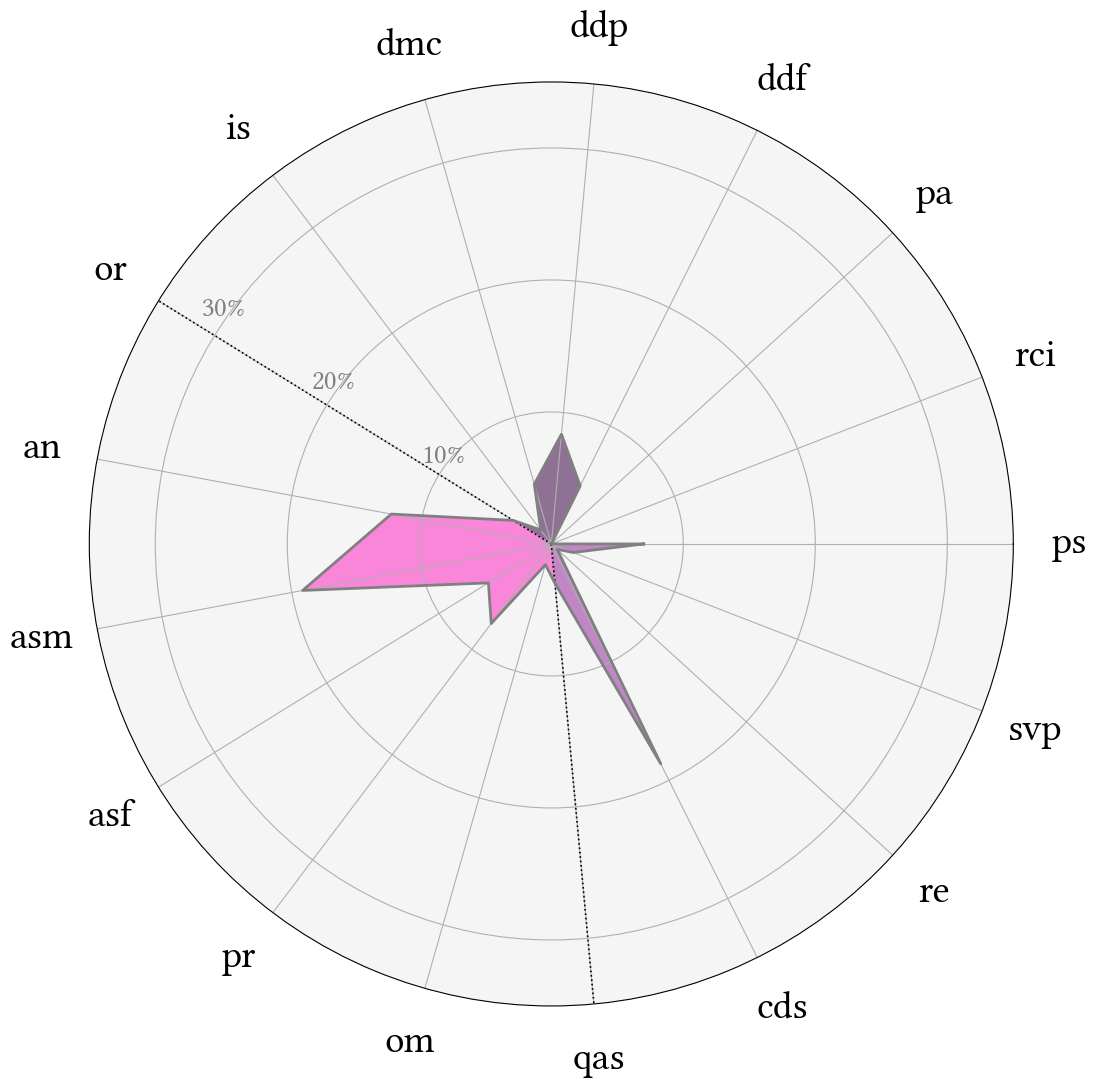

Gerando radar para: tupy...
[Salvo] ../outputs/radares/all/radar_tupy.pdf


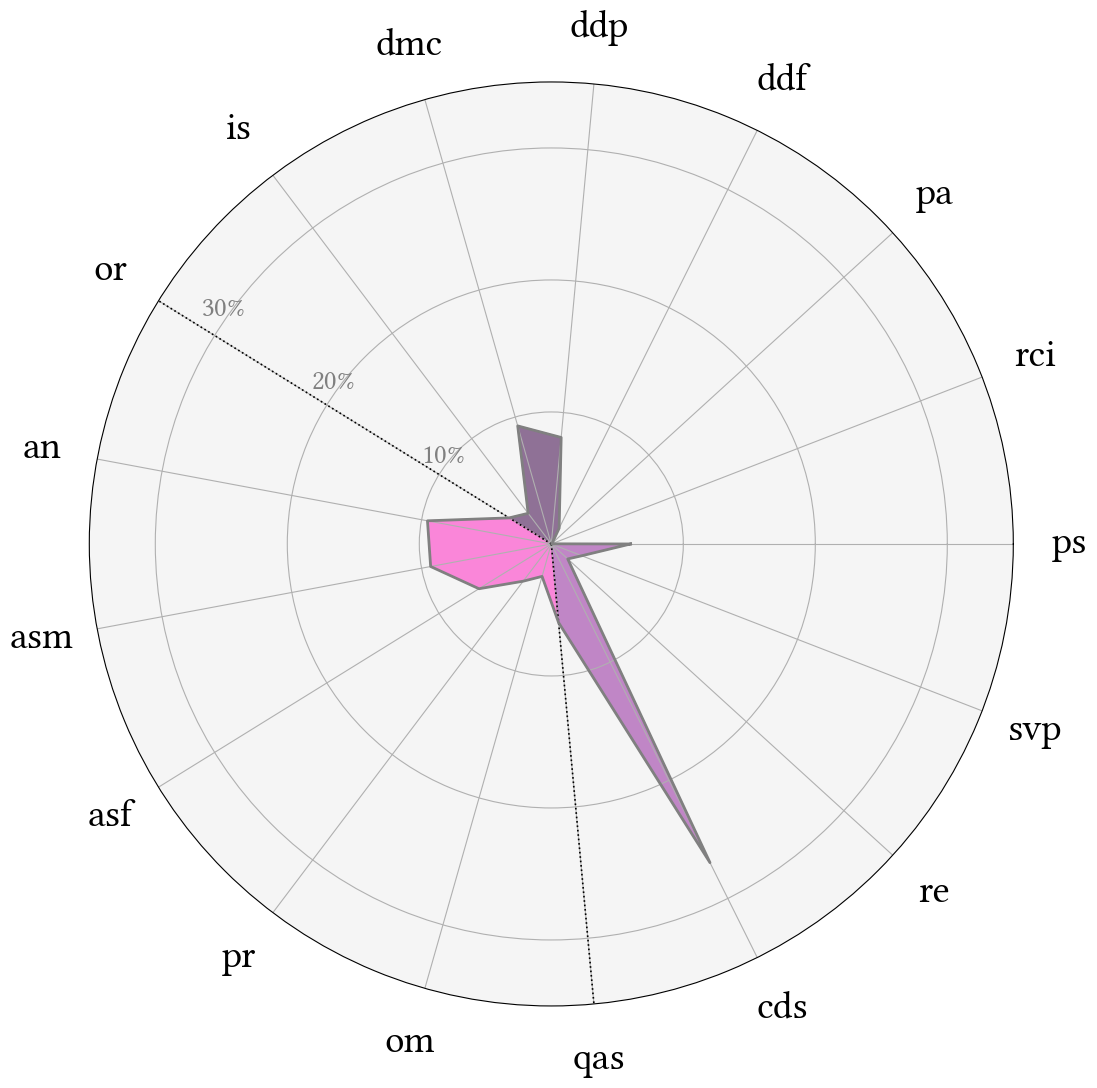

In [15]:
# 1. Calcular a tabela de dados
# (Certifique-se de que 'datasets' é sua lista de objetos Dataset e 'hatebase' está carregado)
df_radar = calcular_distribuicao_lexica(datasets, hatebase, categorias_ordenadas, is_toxic=None)

# 2. Conferir os números (Opcional)
print("Tabela de Distribuição (%):")
display(df_radar.round(1))

# 3. Gerar os Gráficos
# plotar_radares_individuais(df_radar, mapeamento_secoes)
plotar_radares_finais(df_radar, mapeamento_secoes,output_path='../outputs/radares/all', y_limit=35)